# Minimum working notebook using imported functions

In [1]:
import os
from glob import glob
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import mne
mne.set_log_level(verbose=False)
import wandb

from Datasets import *

In [2]:
from utils_folder.callbacks import *
from utils_folder.training_pth import *
from utils_folder.plotting import *
from utils_folder.utils import get_labels_and_preds

In [3]:
wandb.login()

wandb: Currently logged in as: jorgvt (use `wandb login --relogin` to force relogin)


True

In [4]:
config = {
    'epochs':2,
    'classes':5,
    'batch_size':32,
    'learning_rate':0.001,
    'channels':['C3','C4','O1','O2','LOC','ROC','CHIN1'],
    'patients_train':1,
    'patients_test':2,
    'binary':True,
    'metadata': "Awake-Sleep test"
}

In [5]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=2)

In [6]:
class TinySleepNet(nn.Module):
    def __init__(self, sampling_rate, channels, classes):
        super(TinySleepNet, self).__init__()
        self.sampling_rate = sampling_rate
        self.channels = channels
        self.classes = classes

        self.feature_extraction = nn.Sequential(*[
            nn.Conv1d(in_channels=len(channels), out_channels=128, kernel_size=sampling_rate//2, stride=sampling_rate//4),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=8, stride=8),
            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=8, stride=1, padding=3),
            nn.ReLU(),
            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=8, stride=1, padding=3),
            nn.ReLU(),
            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=8, stride=1, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4)
        ])

        self.lstm = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        
        self.classifier = nn.Linear(128*2, classes)

    def forward(self, X):
        X = self.feature_extraction(X)
        # X, _ = self.lstm(X.permute(0,2,1))
        # X = X[:,-1,:]
        X = X.view(X.shape[0],-1)
        X = self.classifier(X)
        return X

In [7]:
def accuracy_fn(Y_pred, Y_true):
    """
    Calculates the accuracy of our model given its predictions and labels.

    Parameters
    ----------
    Y_pred: torch.Tensor
        Raw output from the nn (logits).
    Y_true: torch.Tensor
        Objective labels.
    
    Returns
    -------
    accuracy: float
    """
    Y_pred = torch.softmax(Y_pred, dim=-1)
    Y_pred = Y_pred.argmax(dim=-1)
    accuracy = torch.where(Y_pred==Y_true, 1, 0).sum() / len(Y_true)

    return accuracy.item()

wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1 -> [Train] (Loss) 0.7417 (Acc) 0.6493 | [Val] (Loss) 0.6014 (Acc) 0.9784
val_accuracy improved from -999999.0000 -> 0.9784. Model saved!.
Epoch 2 -> [Train] (Loss) 0.6495 (Acc) 0.6470 | [Val] (Loss) 0.4822 (Acc) 0.9651


loss,0.64949
accuracy,0.64699
val_loss,0.48215
val_accuracy,0.96514
_runtime,43
_timestamp,1625494744
_step,5


loss,█▁
accuracy,█▁
val_loss,█▁
val_accuracy,█▁
_runtime,▁▅████
_timestamp,▁▅████
_step,▁▂▄▅▇█


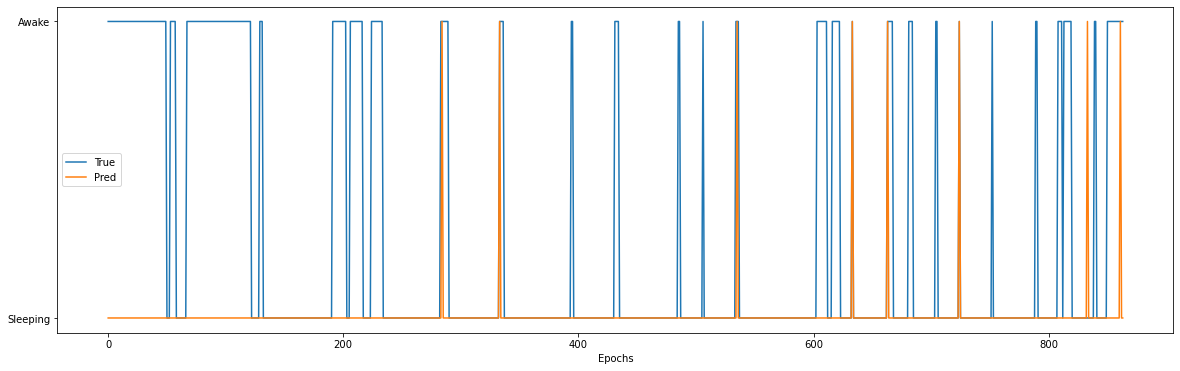

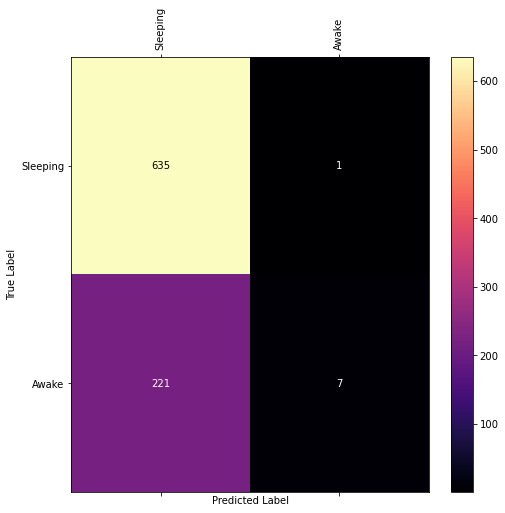

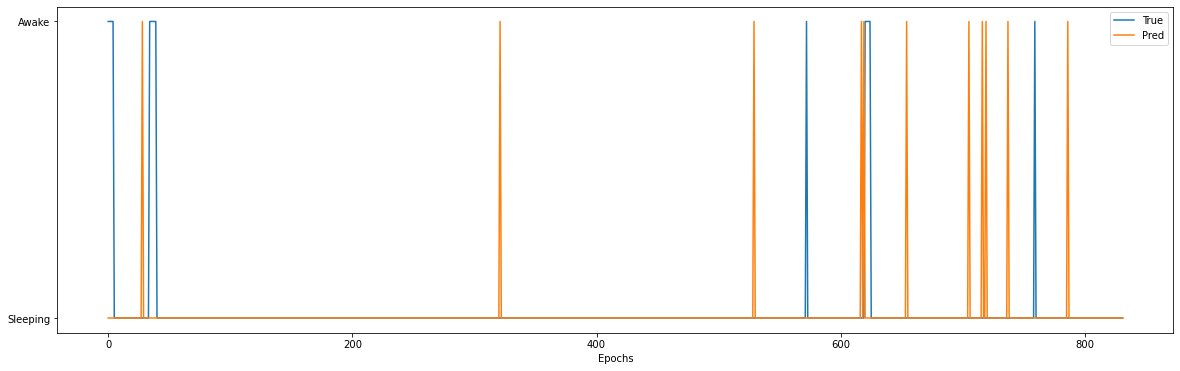

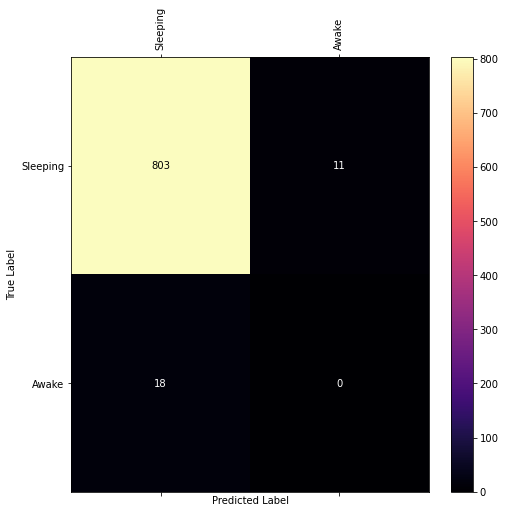

In [8]:
with wandb.init(project='test-pth', entity='jorgvt', config = config):
    configuration = wandb.config

    ## Load the data ##
    path_train = "../Data/PSG1.edf"
    path_test = "../Data/PSG2.edf"
    train = EDFData_PTH(path_train, channels=configuration.channels, binary=configuration.binary)
    trainloader = torch.utils.data.DataLoader(train, batch_size = configuration.batch_size, drop_last=True)
    test = EDFData_PTH(path_test, channels=configuration.channels, binary=configuration.binary)
    testloader = torch.utils.data.DataLoader(test, batch_size = configuration.batch_size, drop_last=True)
    sampling_rate = int(test.sampling_rate)

    ## Define the model ##
    model = TinySleepNet(sampling_rate, configuration.channels, classes=2)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()

    ## Define the metrics ##
    metrics = {
    'accuracy':accuracy_fn
    }

    ## Define the checkpoint object ##
    checkpoint = Checkpoint(os.path.join(wandb.run.dir,'model.pth'), 'val_accuracy', mode='max')

    ## Train the model ##
    h = train_fn(device, model, optimizer, loss_fn, trainloader, testloader, configuration.epochs, metrics, checkpoint=checkpoint)

    ## Get the labels and predictions for the whole datasets
    labels_train, preds_train = get_labels_and_preds(device, model, trainloader)
    labels_test, preds_test = get_labels_and_preds(device, model, testloader)
    
    ## Create and log figures
    ### Train
    plt.figure(figsize=(20,6))
    plot_labels(labels_train, preds_train, label_mapper=train.id_to_class_dict)
    wandb.log({"Labels_Preds_Plot_Train":wandb.Image(plt)})
    plt.figure(figsize=(8,8))
    plot_cm(labels_train, preds_train, train)
    wandb.log({"Confusion_Matrix_Train":wandb.Image(plt)})
    ### Test
    plt.figure(figsize=(20,6))
    plot_labels(labels_test, preds_test, label_mapper=train.id_to_class_dict)
    wandb.log({"Labels_Preds_Plot_Test":wandb.Image(plt)})
    plt.figure(figsize=(8,8))
    plot_cm(labels_test, preds_test, test)
    wandb.log({"Confusion_Matrix_Test":wandb.Image(plt)})